# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## План исследования

- Исследовательский анализ данных
- Обучение модели
- Анализ обученной модели

# Исследовательский анализ данных

Импортируем необходимые библиотеки, модели и функции.

In [1]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Посмотрим на размер нашей выборки.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape[0]

7591

Посмотрим, как распределены наши покупатели по возрастам.

In [3]:
labels.describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99])

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
90%,54.000000
95%,63.000000
99%,82.000000


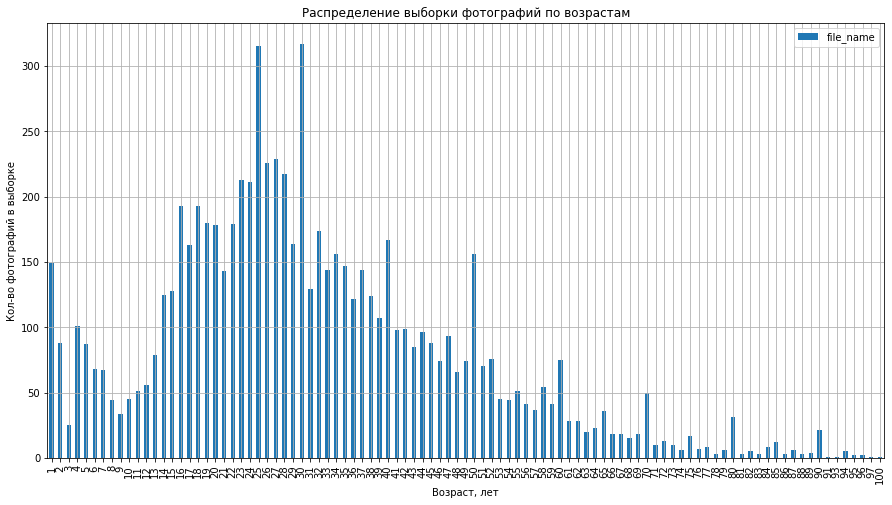

In [5]:
labels.groupby('real_age').count().plot(kind = 'bar', 
                                        figsize = (15,8), 
                                        grid = 'True', 
                                        title = 'Распределение выборки фотографий по возрастам',
                                        xlabel = 'Возраст, лет',
                                        ylabel = 'Кол-во фотографий в выборке'
                                       );

Явно имеются выбросы в бОльшую сторону. 

Взглянем на наши фото, которые модели предстоит анализировать. 

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1234) 

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


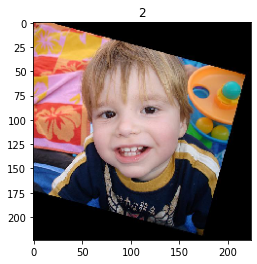

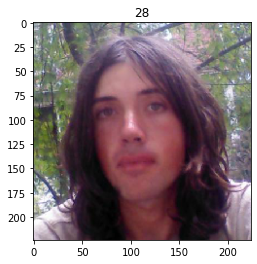

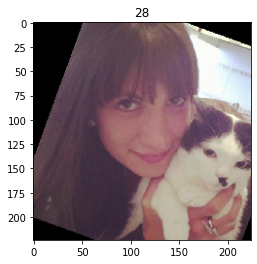

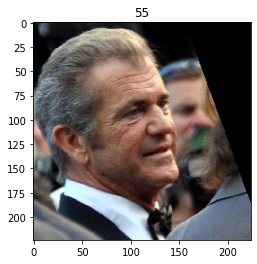

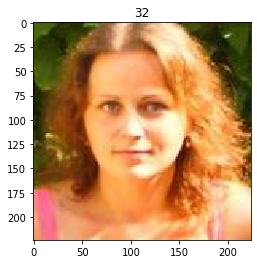

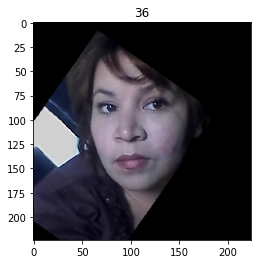

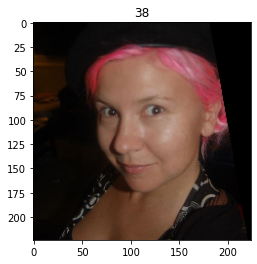

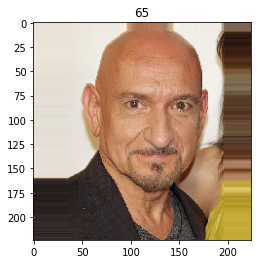

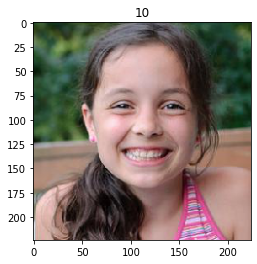

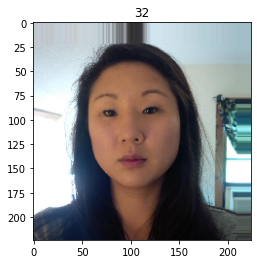

In [20]:
for i in range(0,10):
    plt.figure()
    plt.title(target[i])
    plt.imshow(features[i])

Изображения уже прошли предварительную подготовку: лица отцентрованы. 

### Вывод:

- Первичная аугментация была уже сделана: фотографии смещены и отцентрированы относительно лиц. Предварительная аугментация не требуется, за исключением horizontal_flip.
- Исходя из статистического описания данных, большинство фотографий людей возрастом от 20 до 54 (90-й перцентиль), выбросы имеются только в большую сторону.

## Обучение модели

Используем модель ResNet50 с модификацией верхних слоёв.  
Модель приведена текстом с разбиением по блокам.

```
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=1234)
        
    return train_datagen_flow
```

```
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=1234)

    return test_datagen_flow
```

```
def create_model(input_shape):

    backbone = ResNet50(input_shape = input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu')) 
    model.add(Dropout(0.5, seed = 1234))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error',metrics=['mae'])
    return model
```

```
def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

Вывод при обучении:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 51s - loss: 207.3616 - mae: 10.6105 - val_loss: 602.5554 - val_mae: 19.4437
Epoch 2/8
178/178 - 41s - loss: 86.0956 - mae: 7.0401 - val_loss: 514.3233 - val_mae: 17.4167
Epoch 3/8
178/178 - 41s - loss: 57.5504 - mae: 5.8190 - val_loss: 283.8556 - val_mae: 12.4919
Epoch 4/8
178/178 - 41s - loss: 42.0871 - mae: 4.9420 - val_loss: 116.1303 - val_mae: 8.0602
Epoch 5/8
178/178 - 41s - loss: 37.6843 - mae: 4.6724 - val_loss: 90.6998 - val_mae: 7.0757
Epoch 6/8
178/178 - 42s - loss: 30.6476 - mae: 4.1951 - val_loss: 80.2695 - val_mae: 6.6583
Epoch 7/8
178/178 - 41s - loss: 26.3084 - mae: 3.9158 - val_loss: 75.2477 - val_mae: 6.3949
Epoch 8/8
178/178 - 41s - loss: 25.1847 - mae: 3.7526 - val_loss: 69.1645 - val_mae: 6.1608

60/60 - 10s - loss: 69.1645 - mae: 6.1608
Test MAE: 6.1608
```

Целевой показатель MAE < 8 достигнут.

## Анализ модели

Была использована модель ResNet c верхними слоями:  
- GlobalAveragePooling2D — пулинг с окном во весь тензор,
- Dense - полносвязный слой c большим количеством узлов
- Dropout - случайное исключение части обученных нейронов для минимизации переобучения
- Dense - полносвязный слой с единственным узлом для итогового вывода результата регрессии. 

Необходимое значение MAE (<8) достигнуто.  Модель предсказывает возраст с ошибкой  ~6 лет.

Для изначальных задач бизнеса модель ограниченно применима: 
- Для задачи возрастной сегментации покупателей для последующих рекомендаций модель можно применять с учётом допустимой ошибки.
- Для задачи контроля работы кассиров при продаже товаров 18+ модель малоприменима: в пограничных ситуациях, где она была бы наиболее актуальна, её точность недостаточна.